In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import plot_model

In [34]:
temp = pd.read_csv("obesity.csv")
columns = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
for c in columns:
  dummies = pd.get_dummies(temp[c], prefix=(str(c)+"_"))
  temp = pd.concat([temp, dummies], axis=1)
temp = temp.drop(columns=columns)


d = ['Insufficient_Weight',
       'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I',
       'Obesity_Type_II', 'Obesity_Type_III']
ordinal_encoder = OrdinalEncoder(categories=[d])
temp['NObeyesdad'] = ordinal_encoder.fit_transform(temp[['NObeyesdad']])
y_xgb = temp['NObeyesdad']

temp = temp.drop('NObeyesdad', axis=1)
scaler = MinMaxScaler(feature_range=(0, 1))
X_rescaled = scaler.fit_transform(temp)
X = pd.DataFrame(data = X_rescaled, columns = temp.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y_xgb, test_size=0.2, random_state=15)
eval_set = [(X_train, y_train), (X_test, y_test)]

In [35]:
trial = XGBClassifier(objective='multi:softprob',eval_metric=["merror"])
trial.fit(X_train, y_train, eval_set=eval_set, verbose=True)
y_pred = trial.predict(X_test)
accuracy = trial.score(X_test, y_test)
print(" Test Accuracy: %.4f%%" % (accuracy * 100.0))
y_train_pred = trial.predict(X_train)
train_accuracy = trial.score(X_train, y_train)
print(" Train Accuracy: %.4f%%" % (train_accuracy * 100.0))


[0]	validation_0-merror:0.07168	validation_1-merror:0.12766
[1]	validation_0-merror:0.05273	validation_1-merror:0.09456
[2]	validation_0-merror:0.04384	validation_1-merror:0.08511
[3]	validation_0-merror:0.03614	validation_1-merror:0.07801
[4]	validation_0-merror:0.02903	validation_1-merror:0.07329
[5]	validation_0-merror:0.02488	validation_1-merror:0.06856
[6]	validation_0-merror:0.02073	validation_1-merror:0.06619
[7]	validation_0-merror:0.01422	validation_1-merror:0.05201
[8]	validation_0-merror:0.01244	validation_1-merror:0.04965
[9]	validation_0-merror:0.01066	validation_1-merror:0.04965
[10]	validation_0-merror:0.01007	validation_1-merror:0.04492
[11]	validation_0-merror:0.00711	validation_1-merror:0.03783
[12]	validation_0-merror:0.00415	validation_1-merror:0.03546
[13]	validation_0-merror:0.00178	validation_1-merror:0.03073
[14]	validation_0-merror:0.00118	validation_1-merror:0.03073
[15]	validation_0-merror:0.00118	validation_1-merror:0.02837
[16]	validation_0-merror:0.00118	v

The test accuracy here is really high at 97.8723% so we should look for any overfitting, because this model seems to be great at first glance.

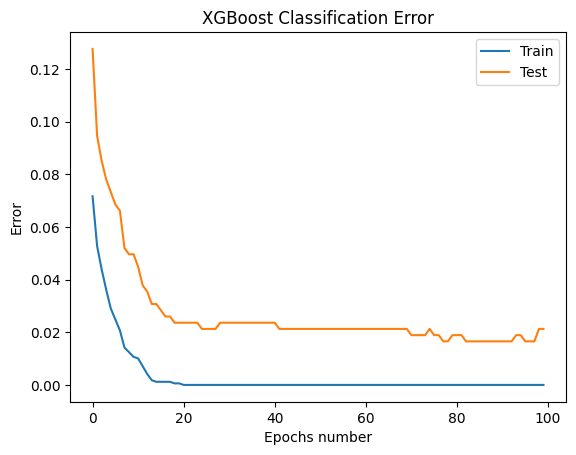

In [36]:
results = trial.evals_result()
epochs = len(results['validation_0']['merror'])
x = range(0, epochs)
fig, axis = plt.subplots()
axis.plot(x, results['validation_0']['merror'], label='Train')
axis.plot(x, results['validation_1']['merror'], label='Test')
axis.legend()
plt.ylabel('Error')
plt.title('XGBoost Classification Error')
plt.xlabel('Epochs number')
plt.show()

After plotting the error term for each epoch for both the train and test set as our validation data, we can see that after around 20 epochs the model varies very slightly and doesn't improve the error. Therefore, we created an early stopping model that tries to stop the model after 20 epochs, so no overfitting happens since past 20 epochs the model doesn't improve.

In [37]:
early_stopping_rounds = 2 #typically set to 0.1 * (20) which is the epoch we want to stop at
earlystopxgb = XGBClassifier(objective='multi:softprob', num_class=7,eval_metric=['merror'],early_stopping_rounds=early_stopping_rounds)
earlystopxgb.fit(X_train, y_train, eval_set=[(X_test, y_test)])

y_pred = earlystopxgb.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Test Recall:", recall_score(y_test, y_pred, average='weighted'))

[0]	validation_0-merror:0.12766
[1]	validation_0-merror:0.09456
[2]	validation_0-merror:0.08511
[3]	validation_0-merror:0.07801
[4]	validation_0-merror:0.07329
[5]	validation_0-merror:0.06856
[6]	validation_0-merror:0.06619
[7]	validation_0-merror:0.05201
[8]	validation_0-merror:0.04965
[9]	validation_0-merror:0.04965
[10]	validation_0-merror:0.04492
[11]	validation_0-merror:0.03783
[12]	validation_0-merror:0.03546
[13]	validation_0-merror:0.03073
[14]	validation_0-merror:0.03073
[15]	validation_0-merror:0.02837
[16]	validation_0-merror:0.02600
[17]	validation_0-merror:0.02600
[18]	validation_0-merror:0.02364
[19]	validation_0-merror:0.02364
[20]	validation_0-merror:0.02364
Test Accuracy: 0.9763593380614657
Test Precision: 0.9763584370850036
Test Recall: 0.9763593380614657


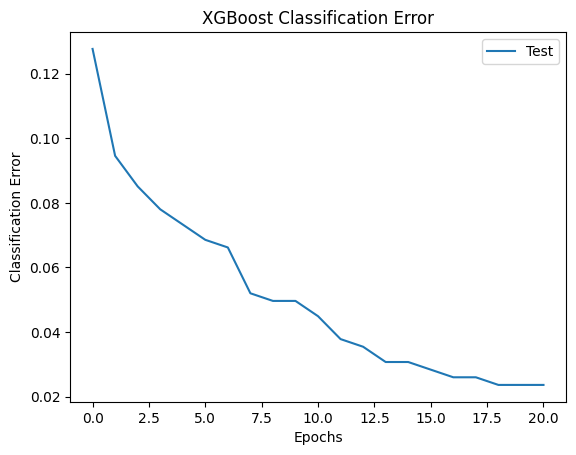

In [38]:
results = earlystopxgb.evals_result()
epochs = len(results['validation_0']['merror'])
x = range(0,  epochs)
fig, axis = plt.subplots()
axis.plot(x, results['validation_0']['merror'], label='Test')
axis.legend()
plt.ylabel('Classification Error')
plt.xlabel('Epochs')
plt.title('XGBoost Classification Error')
plt.show()

Now with the use of early-stopping, the test accuracy is 91.5% which is more reasonable and the validation accuracy was high at 97.16%, while the training accuracy was at 98.4%.

In [39]:
#XGB Cross Validation - https://machinelearningmastery.com/evaluate-gradient-boosting-models-xgboost-python/
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
def train_evaluateXGB(model, xtrain, ytrain, xtest, ytest):
  model.fit(xtrain, ytrain, eval_set=[(xtest,ytest)])
  accuracy = model.score(xtest, ytest)
  return accuracy
kFold = StratifiedKFold(n_splits = 10)
i=0
sum=0
for train, test in kFold.split(temp,y_xgb):
  print("Current Iteration:",i)
  modelxgb = None
  modelxgb = earlystopxgb
  acc = train_evaluateXGB(modelxgb,temp.loc[[x for x in train]],y_xgb.loc[[x for x in train]],temp.loc[[x for x in test]],y_xgb.loc[[x for x in test]])
  print("Accuracy for each Fold: ", acc)
  i+=1
  sum += acc

print("Mean accuracy:", (sum/i))
#Mean accuracy: 0.9237950460520432

Current Iteration: 0
[0]	validation_0-merror:0.22642
[1]	validation_0-merror:0.23585
[2]	validation_0-merror:0.22170
[3]	validation_0-merror:0.22642
[4]	validation_0-merror:0.22642
Accuracy for each Fold:  0.7783018867924528
Current Iteration: 1
[0]	validation_0-merror:0.17536
[1]	validation_0-merror:0.16114
[2]	validation_0-merror:0.13744
[3]	validation_0-merror:0.11848
[4]	validation_0-merror:0.12796
[5]	validation_0-merror:0.11374
[6]	validation_0-merror:0.11374
[7]	validation_0-merror:0.10427
[8]	validation_0-merror:0.09479
[9]	validation_0-merror:0.09005
[10]	validation_0-merror:0.08531
[11]	validation_0-merror:0.09005
[12]	validation_0-merror:0.08531
Accuracy for each Fold:  0.9146919431279621
Current Iteration: 2
[0]	validation_0-merror:0.11848
[1]	validation_0-merror:0.06161
[2]	validation_0-merror:0.04739
[3]	validation_0-merror:0.04265
[4]	validation_0-merror:0.04265
[5]	validation_0-merror:0.04265
Accuracy for each Fold:  0.957345971563981
Current Iteration: 3
[0]	validation

Our cross-validation ran well too giving a mean accuracy of 93.8%, but performs not as well in the first fold, but really good on all of the other folds.

In Conclusion

In [40]:
import pickle

In [41]:
filename = 'xgb_model.sav'
pickle.dump(earlystopxgb, open(filename, 'wb'))
